# Análise de Mensagens de Commit

Este notebook tem como objetivo analisar mensagens de commit de estudantes utilizando técnicas básicas de Processamento de Linguagem Natural (PLN). O objetivo final é treinar um modelo que seja capaz de identificar mensagens que não são minimamente explicativas, servindo como base para um gancho (`hook`) do Git que bloqueie commits mal escritos.

## Carregamento dos Dados

Inicialmente, carregamos os dados extraídos da API do GitHub. As mensagens de commit foram coletadas de projetos de estudantes, organizadas em um arquivo Excel. Também realizamos um pré-processamento para limpar dados nulos e ajustar os nomes das colunas.


In [12]:
import pandas as pd

df = pd.read_excel('data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df = df.dropna()
df = df.reset_index(drop=True)
df.head(3)

,0,code,message,message_english,is_code_related
0,1,\nFile:amigos.html\nCode modifications:\n@@ -2...,Merge pull request #1 from mumuvrf/franco\n\na...,Merge pull request #1 from mumuvrf/franco\n\na...,1
1,2,\nFile:amigos.html\nCode modifications:\n@@ -2...,alteracao campus mobile,Change Mobile Campus,0
2,3,\nFile:css/index.css\nCode modifications:\n@@ ...,Corrige os botões,Corrects the buttons,1


## Ajuste das Variáveis

Algumas variáveis são transformadas para facilitar a leitura e posterior modelagem. Por exemplo, a coluna `is_code_related`, que inicialmente possui valores binários, é convertida em texto para facilitar a interpretação.


In [13]:
df['is_code_related'] = df['is_code_related'].apply(lambda x: "yes" if x == 1 else "no")

## Treinamento do Modelo

Utilizamos a técnica de Bag-of-Words para transformar as mensagens de commit em vetores numéricos, tornando possível a aplicação de modelos estatísticos. Nesta etapa, também removemos palavras irrelevantes (stopwords) e aplicamos o `CountVectorizer`.
Com os dados vetorizados, treinamos um modelo de Regressão Logística para classificar mensagens como válidas ou inválidas. O modelo é simples, mas eficaz para este tipo de tarefa binária.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score

model = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('classifier', LogisticRegression())
])

X_train, X_test, y_train, y_test = train_test_split(df['message_english'], df['is_code_related'], test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

recall = recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall:.2f}')

Recall: 0.88


## Avaliação do Modelo

Avaliamos o desempenho do modelo utilizando a métrica de *recall*, que é especialmente relevante neste caso, pois nos interessa evitar o excesso de falsos negativos. Também usamos a matriz de confusão para entender o equilíbrio entre classes.

[[0.86363636 0.13636364]
 [0.09821429 0.90178571]]


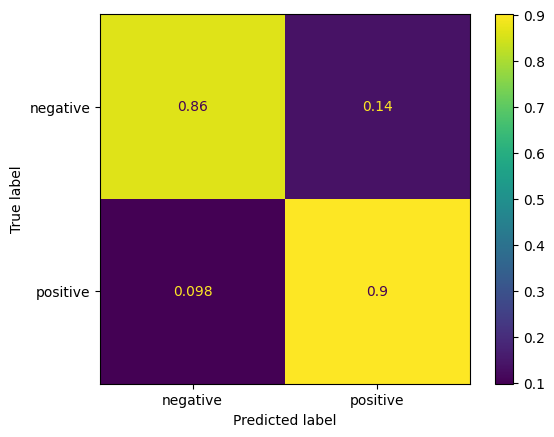

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=['negative', 'positive']).plot()

## Salvamento do Modelo

Depois de ajustar e validar o modelo, salvamos seus parâmetros em um arquivo `.pkl` para que possam ser reutilizados por um gancho de pré-commit no Git.


In [ ]:
import joblib

# Save the entire pipeline (vectorizer + classifier)
joblib.dump(model, './scripts/models/commit_message_classifier.pkl')